# Bayesian SIR

Antonio Feltrin, Giosuè Sardo Infirri, Riccardo Tancredi, Simone Toso


## Scaletta
 - MCMC con un solo parametro

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.special import gamma as gammafunc
from scipy.stats import gamma as gammadist
from tqdm import tqdm

## Data generation

In [2]:
#Parameter initialization
N = int(1e6)
T = 101
I0 = 50

betas = 25*[0.3]+25*[.4]+25*[.25]+26*[.2]
gammas = 25*[0.05]+25*[.15]+25*[.2]+26*[.25]

#Simulation
initial_conf = np.array([N-I0, I0, 0])

configurations = np.zeros([T, 3])
configurations[0, :] = initial_conf

for tt in range(1, T):
    beta_true = betas[tt]
    gamma_true = gammas[tt]
    
    delta_I = npr.binomial(configurations[tt-1][0],
                           1 - np.exp(-beta_true*configurations[tt-1][1]/N))
    delta_R = npr.binomial(configurations[tt-1][1],
                           gamma_true)
    configurations[tt][0] = configurations[tt-1][0] - delta_I
    configurations[tt][1] = configurations[tt-1][1] + delta_I - delta_R
    configurations[tt][2] = configurations[tt-1][2] + delta_R

Text(0.5, 1.0, 'Simulated data with varying parameters')

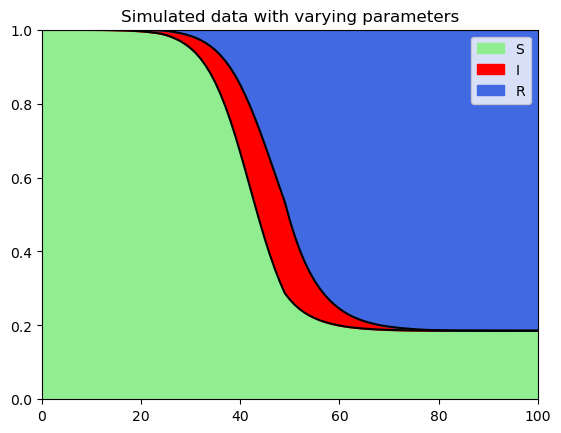

In [3]:
xs = np.arange(0, T)
ss = configurations[:, 0] / N
ii = configurations[:, 1]/N + ss
rr = configurations[:, 2]/N + ii

plt.plot(ss, c = "black")
plt.plot(ii, c = "black")
plt.plot(rr, c = "black")
plt.ylim([0, 1])

plt.fill_between(xs, 0, ss, label = "S", color = "lightgreen")
plt.fill_between(xs, ss, ii, label = "I", color = "red")
plt.fill_between(xs, ii, rr, label = "R", color = "royalblue")

plt.xlim([0, T-1])
plt.legend()
plt.title("Simulated data with varying parameters")

## MCMC

 - Update delta
 - Update b,r
 - Update gamma

In [4]:
def mylog(x):
    try:
        x = np.array(x)
        mask = x > 0
        output = np.zeros(len(x))
        output[mask] = np.log(x[mask])
        output[~mask] = -1022
        return output
    except:
        return np.log(x) if x > 0 else -1022

In [5]:
[1, 2] == [1, 2]

True

### Delta update

In [72]:
etaprova = np.array([1,1,2,2,2,3,3,3,4,4])
i = 1
indic = etaprova == i
betaprova = np.array([1,2,3,4,5,6,7,8,9,10])
betaprova*indic

array([1, 2, 0, 0, 0, 0, 0, 0, 0, 0])

In [6]:
def conditional_betagamma(delta, beta, gamma):
    K = np.sum(delta).astype(int)
    eta = np.cumsum(delta)
    total = 0
    for ii in range(K):
        indic = eta == ii
        total += 2*mylog(gammafunc(0.1 + np.sum(indic)))
        total -= mylog(0.1 + np.sum(beta*(indic)))*(0.1 + np.sum(indic))
        total -= mylog(0.1 - np.sum(mylog(gamma)*(indic)))*(0.1 + np.sum(indic))
    return total

def JJ(delta_proposed, delta_now, T):
    
    sum_proposed = np.sum(delta_proposed).astype(int)
    sum_now = np.sum(delta_now).astype(int)
    
    if sum_proposed == sum_now:
        return 1
    elif [sum_proposed, sum_now] == [1, 2] or [sum_proposed, sum_now] == [T, T-1]:
        return 3/(T-1)
    elif [sum_proposed, sum_now] == [2, 1] or [sum_proposed, sum_now] == [T-1, T]:
        return (T-1)/3
    elif sum_proposed < sum_now:
        return (sum_now - 1)/(T-sum_proposed)
    else:
        return (T- sum_now) / (sum_proposed - 1)
    
def update_delta(delta_proposed, delta_now, beta_now, gamma_now, p, T):
    #Step 1: evaluate first term pi/pi
    difference = np.sum(delta_proposed - delta_now)
    first_term = difference*mylog(p/(1-p))
    
    #Step 2: evaluate second term:
    second_term = conditional_betagamma(delta_proposed, beta_now, gamma_now)
    second_term -= conditional_betagamma(delta_now, beta_now, gamma_now)
    
    #Step 3: evaluate third term
    third_term = mylog(JJ(delta_proposed, delta_now, T))
    
    log_m = first_term + second_term + third_term
    
    print("first_term ",first_term, "second_term ",second_term, "third_term ", third_term)
    
    probability = min(0, log_m)
    
    print("Probability: ", np.exp(probability))
        
    eps = np.log(npr.uniform()) 
   # print(f"eps {eps}")
    if eps < probability:
        print("Accepted")
        return delta_proposed
    else:
        return delta_now
    
def propose_delta(delta_now, T):
    delta = delta_now.copy()
    K = np.sum(delta).astype(int)
    if K == 1:
        probs = np.array([1,0,0])
    elif K==T:
        probs = np.array([0,1,0])
    else:
        probs = np.array([1,1,1])/3
        
    choice = npr.choice([0,1,2], p = probs)
    
    #print(f"choice:{choice}")
    if choice == 0: #add
        index = npr.choice(np.where(delta_now == 0)[0])
        delta[index] += 1
        print("Proposed to add: ", index)
    elif choice == 1: #delete
        index = npr.choice(np.where(delta_now[1:] == 1)[0]) + 1
        print("Proposed to delete: ", index)
        delta[index] -= 1
    else: #swap
        candidates = np.where((delta_now[1:T-1] - delta_now[2:T]) != 0)[0] + 1
        index_0 = npr.choice(candidates)
        delta[index_0] = 1 - delta[index_0]
        delta[index_0+1] = 1 - delta[index_0+1]
        print("Proposed to swap: ", index_0)

    
    return delta  

In [7]:
np.array(list(range(10)))[1:1], np.array(list(range(10)))[2:10]

(array([], dtype=int64), array([2, 3, 4, 5, 6, 7, 8, 9]))

In [8]:
delta_now = np.array([1, 0,0,0,0,0])
npr.choice(np.where(delta_now == 0)[0])

4

In [9]:
d_prova = np.array([1, 0,0,1,1,0,0,1])
print(propose_delta(d_prova, len(d_prova)))

Proposed to swap:  2
[1 0 1 0 1 0 0 1]


In [10]:
# Try one step
p = 0.01
T = 100

# Initialize delta
delta_0 = (npr.uniform(size = T) < p).astype(int)
delta_0[0] = 1

KK = np.sum(delta_0)
eta = np.cumsum(delta_0)
rb = npr.gamma(shape = .1, scale = 10, size = (2,KK))
r_0 = rb[0]
b_0 = rb[1]

r_0 = r_0[eta-1]
b_0 = b_0[eta-1]

beta_0 = npr.exponential(1/b_0)
gamma_0 = npr.beta(r_0, 1)

delta_1 = propose_delta(delta_0, T)
prova = update_delta(delta_1, delta_0, beta_0, gamma_0, p, T)

delta_1 = prova

Proposed to delete:  98
first_term  4.59511985013459 second_term  602.7260251842123 third_term  -3.4965075614664802
Probability:  1.0
Accepted


### b and r update

In [11]:
def update_b(delta_now, beta_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    b_next = np.zeros(K)
    for kk in range(K):
        b_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1+np.sum(beta_now*(eta==kk))))
    return b_next

def update_r(delta_now, gamma_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    r_next = np.zeros(K)
    for kk in range(K):
        r_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1 + np.sum(-mylog(gamma_now)*(eta==kk))))

    return r_next

### Update beta and gamma

In [12]:
#For each beta find a sample from posterior
def update_beta(S, I, N, T, b): #cool beta distribution trick
    new_betas = np.zeros(T)
    for tt in range(T):
        C = I[tt]/N
        D = -S[tt+1]+S[tt]
        A = C*(S[tt]-D)+b[tt]
        y = npr.beta(a = A/C, b = D+1)
        new_betas[tt] = -1/C*np.log(y)
        
    return new_betas

def update_gamma(I, R, N, T, r):
    new_gammas = np.zeros(T)
    for tt in range(T):
        delta_R = R[tt+1]-R[tt]
        new_gammas[tt] = npr.beta(delta_R + r[tt], I[tt]-delta_R+1)
    return new_gammas

# Let's try a full run

In [13]:
delta_0

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [74]:
n_steps = int(250)

p = 0.1
T = 100

burnin = 0
thin = 10

betas_run = np.zeros([T, n_steps])
gammas_run = np.zeros([T, n_steps])
bs_run = np.zeros([T, n_steps])
rs_run = np.zeros([T, n_steps])
deltas_run = np.zeros([T, n_steps])


# Initialize parameters
delta_0 = (npr.uniform(size = T) < p).astype(int)
delta_0[0] = 1

KK = np.sum(delta_0)
eta = np.cumsum(delta_0)
rb = npr.gamma(shape = .1, scale = 10, size = (2,KK))
r_0 = rb[0]
b_0 = rb[1]

r_0 = r_0[eta-1]
b_0 = b_0[eta-1]

beta_0 = npr.exponential(1/b_0)
gamma_0 = npr.beta(r_0, 1)

delta = delta_0.copy()
beta = beta_0.copy()
gamma = gamma_0.copy()
r = r_0.copy()
b = b_0.copy()


for step in tqdm(range(n_steps), desc='Buffering...', colour='green'):
   #if step%1000 == 0:
   #     print(step)

    
    print("Delta beginning: \n", delta)
    delta_new = propose_delta(delta, T)
    delta = update_delta(delta_new, delta, beta, gamma, p, T)
    print("Delta after: \n", delta)

    b = update_b(delta, beta)
    r = update_r(delta, gamma)

    eta = np.cumsum(delta)
    b = b[eta-1]
    r = r[eta-1]
    
    beta = update_beta(configurations[:,0], configurations[:,1], N, T, b)
    gamma = update_gamma(configurations[:,1], configurations[:,2], N, T, r)
    
    if step >= burnin and step % 1 == 0:
        betas_run[:, step] = beta
        gammas_run[:,step] = gamma
        deltas_run[:,step] = delta
        bs_run[:,step] = b
        rs_run[:,step] = r
    
    

(100,)
(100,)


Buffering...:   9%|██████████████▌                                                                                                                                               | 23/250 [00:00<00:01, 225.39it/s]

Delta beginning: 
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to delete:  39
first_term  2.197224577336219 second_term  -25.68338129977792 third_term  -1.9924301646902063
Probability:  8.605781362013612e-12
Delta after: 
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to add:  34
first_term  -2.197224577336219 second_term  0.7539582154904991 third_term  1.900958761193047
Probability:  1.0
Accepted
Delta after: 
 [1 0 0 0 0 0 0 0 1 0 0 0 

Buffering...:  20%|████████████████████████████████▏                                                                                                                             | 51/250 [00:00<00:00, 251.87it/s]

first_term  -0.0 second_term  -0.640322451852569 third_term  0.0
Probability:  0.527122425033791
Accepted
Delta after: 
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to swap:  49
first_term  -0.0 second_term  -0.32916405130843884 third_term  0.0
Probability:  0.7195249680518554
Accepted
Delta after: 
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 0

Buffering...:  31%|████████████████████████████████████████████████▋                                                                                                             | 77/250 [00:00<00:00, 251.46it/s]

Proposed to delete:  36
first_term  2.197224577336219 second_term  -1.0602738244647583 third_term  -1.5856272637403819
Probability:  0.6384726042387813
Accepted
Delta after: 
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to add:  35
first_term  -2.197224577336219 second_term  0.7314890760066675 third_term  1.5856272637403819
Probability:  1.0
Accepted
Delta after: 
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 0 0 0 

Buffering...:  42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 104/250 [00:00<00:00, 258.23it/s]

first_term  -2.197224577336219 second_term  -28.518542014014898 third_term  1.5856272637403819
Probability:  2.2332700049000294e-13
Delta after: 
 [1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0
 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0
 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to add:  33
first_term  -2.197224577336219 second_term  1.8521676612319027 third_term  1.5856272637403819
Probability:  1.0
Accepted
Delta after: 
 [1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0
 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0

Buffering...:  52%|█████████████████████████████████████████████████████████████████████████████████▋                                                                           | 130/250 [00:00<00:00, 246.44it/s]

Delta beginning: 
 [1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0
 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to delete:  35
first_term  2.197224577336219 second_term  -1.9198957388503288 third_term  -1.5163474893680884
Probability:  0.2896683442767941
Delta after: 
 [1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0
 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0
 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to swap:  15
first_term  -0.0 second_term  0.08213430163671376 third_term  0.0
Probability:  1.0
Accepted
Delta after: 
 [1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 

first_term  -0.0 second_term  0.0017155687884127246 third_term  0.0
Probability:  1.0
Accepted
Delta after: 
 [1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1
 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1
 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to swap:  18
first_term  -0.0 second_term  -0.3143510627817534 third_term  0.0
Probability:  0.7302626151284449
Accepted
Delta after: 
 [1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1
 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1
 1 0 1 1 0 1 0 1 1 1

Buffering...:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 178/250 [00:00<00:00, 211.78it/s]

Delta beginning: 
 [1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1
 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to swap:  5
first_term  -0.0 second_term  -0.030155892690487462 third_term  0.0
Probability:  0.9702942599748403
Accepted
Delta after: 
 [1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1
 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1
 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to swap:  51
first_term  -0.0 second_term  1.329196457028246 third_term  0.0
Probability:  1.0
Accepted
Delta after: 
 [1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1
 

Proposed to delete:  41
first_term  2.197224577336219 second_term  -1.6151247439681882 third_term  -1.1526795099383855
Probability:  0.5651977118497487
Delta after: 
 [1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0
 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0
 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to add:  1
first_term  -2.197224577336219 second_term  1.996613166032887 third_term  1.0986122886681098
Probability:  1.0
Accepted
Delta after: 
 [1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0
 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 1 0 0 0 1 0 0 0 1 1 1 1 0

Buffering...:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 222/250 [00:00<00:00, 207.75it/s]

Delta beginning: 
 [1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1 0
 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to swap:  26
first_term  -0.0 second_term  -0.4952354078985266 third_term  0.0
Probability:  0.609427426378953
Accepted
Delta after: 
 [1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0
 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0
 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to add:  45
first_term  -2.197224577336219 second_term  2.346685792051673 third_term  1.0986122886681098
Probability:  1.0
Accepted
Delta after: 
 [1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1

Proposed to add:  77
first_term  -2.197224577336219 second_term  -37.20782156023047 third_term  1.3249254147435985
Probability:  2.8974349861721286e-17
Delta after: 
 [1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0
 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0
 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to delete:  34
first_term  2.197224577336219 second_term  -2.042268988541366 third_term  -1.3862943611198906
Probability:  0.2919015262898435
Accepted
Delta after: 
 [1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0
 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 1

Buffering...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 222.95it/s]

Proposed to add:  83
first_term  -2.197224577336219 second_term  -41.326771503032866 third_term  1.3862943611198906
Probability:  5.009895455120676e-19
Delta after: 
 [1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0
 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0
 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Proposed to swap:  41
first_term  -0.0 second_term  0.3039748901746293 third_term  0.0
Probability:  1.0
Accepted
Delta after: 
 [1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0
 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Delta beginning: 
 [1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0

In [75]:
deltas_run[0, :] == 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [57]:
betas_run[:, burnin::10]

array([[0.42209938, 0.3065913 , 0.28791596, ..., 0.31086591, 0.33310601,
        0.30693149],
       [0.19285203, 0.24368992, 0.32074806, ..., 0.15567397, 0.28908579,
        0.20020382],
       [0.40572612, 0.24755556, 0.32299006, ..., 0.40001039, 0.44187992,
        0.29885719],
       ...,
       [0.22037355, 0.74879745, 1.59789083, ..., 0.32404116, 0.13135069,
        0.19044178],
       [0.21127389, 0.14118719, 0.07685955, ..., 0.05373691, 0.20764058,
        0.89164236],
       [0.27845305, 1.65167038, 0.08416223, ..., 0.74401148, 1.22289384,
        0.67139715]])

### Bayesian estimator for delta

In [58]:
#Keep column which are not empty

deltas_samples = deltas_run[:, burnin::10]
bs_samples = bs_run[:, burnin::10]
rs_samples = rs_run[:, burnin::10]
betas_samples = betas_run[:, burnin::10]
gammas_samples = gammas_run[:, burnin::10]

In [59]:
#Every row is a timestep
beta_mean = np.mean(betas_samples, axis = 1)
beta_mean

array([0.33530589, 0.23549602, 0.31678634, 0.32659519, 0.26352938,
       0.28987451, 0.26881891, 0.31431505, 0.27890588, 0.29679468,
       0.31464805, 0.34469043, 0.30635495, 0.3152724 , 0.33490227,
       0.28936713, 0.28026783, 0.29170346, 0.29448076, 0.30550518,
       0.30194638, 0.3064558 , 0.2965921 , 0.3004513 , 0.39784838,
       0.41370499, 0.40845443, 0.3988714 , 0.40392059, 0.40304857,
       0.3979779 , 0.40467989, 0.40154357, 0.39950511, 0.40055682,
       0.40020651, 0.39903325, 0.40096917, 0.40032873, 0.40244826,
       0.39845476, 0.40121244, 0.39951826, 0.39727779, 0.40211869,
       0.3985669 , 0.39670174, 0.39927841, 0.39977006, 0.24635542,
       0.25238986, 0.25405388, 0.24964993, 0.25443569, 0.25012366,
       0.25517777, 0.24686703, 0.25459794, 0.25435466, 0.25788103,
       0.25362681, 0.25526985, 0.2478312 , 0.25391357, 0.25471509,
       0.23420992, 0.25294985, 0.23855542, 0.2673583 , 0.24793172,
       0.25923696, 0.24625896, 0.26893226, 0.24995272, 0.20861

In [60]:
beta = np.mean(betas_samples, axis = 1)
beta_mean.reshape(4, 25).mean(axis=1)

array([0.30427633, 0.39498015, 0.25075551, 0.26948563])

In [61]:
gamma = np.mean(gammas_samples, axis = 1)
gamma.reshape(4, 25).mean(axis=1)
#plt.plot(gamma)

array([0.06035562, 0.15210738, 0.20221397, 0.24816606])

In [62]:
deltas_run[:, (np.sum(deltas_run, axis = 0)) > 3]#[:, -2]

array([], shape=(100, 0), dtype=float64)

In [63]:
deltas_samples#.shape

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
etas_samples = np.cumsum(deltas_samples, axis=0)

In [65]:
etas_samples

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [2., 1., 1., ..., 1., 1., 1.],
       ...,
       [2., 1., 1., ..., 1., 1., 1.],
       [2., 1., 1., ..., 1., 1., 1.],
       [2., 1., 1., ..., 1., 1., 1.]])